# 1 包、超参数、常量、GPU配置

In [1]:
import os
import tensorflow as tf
from keras.backend import set_session

# GPU 配置
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.compat.v1.Session(config=config))

Using TensorFlow backend.


In [2]:
import numpy as np


BASE = '/home/zengrui/datasets/ReID_Market-1501'
TRAIN_DATA_DIR = f'{BASE}/bounding_box_train'
TEST_DATA_DIR = f'{BASE}/bounding_box_test'
QUERY_DATA_DIR = f'{BASE}/query'


BATCH_SIZE = 256
CLASSES = 1501
EPOCHS = 20
LR = 0.1


HEIGHT, WIDTH = 128, 64  # 图片大小

# 2 数据集定义

## 2.1 图像预处理器

定义数据集transform生成器。

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1. / 255,  # 数据重缩放因子
                               width_shift_range=0.2,  # 水平方向随机移动的程度
                               height_shift_range=0.2,  # 竖直方向随机移动的程度
                               shear_range=0.2,  # 错切变换角度
                               zoom_range=0.2,  # 随机缩放范围
                               horizontal_flip=True,
                               rotation_range=30,  # 随即旋转度数范围
#                                validation_split=0.1,  # 保留用于验证的图像的比例
                               fill_mode='nearest',
                              )
test_gen = ImageDataGenerator(rescale=1. / 255)

## 2.2 数据集读出

In [4]:
import get_dataset

images, labels = get_dataset.get(TRAIN_DATA_DIR, CLASSES)

Found 12936 images belonging to 751 classes.


## 2.3 生成数据集（文件名式分类）

In [19]:
train_data = train_gen.flow(images, labels,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
#                             save_to_dir='/home/zengrui/test',
#                             subset='training'
                           )
# val_data = train_gen.flow(images, labels,
#                             batch_size=BATCH_SIZE,
#                             shuffle=True,
#                             save_to_dir='/home/zengrui/test',
#                             subset='validation')

# 3 网络模型定义

定义回调函数。

In [27]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

train_callbacks = [
#     ModelCheckpoint(filepath='./checkpoint/model.{epoch:02d}-{val_loss:.2f}.ckpt',
#                     save_weights_only=True,
#                     verbose=1,
#                     period=10,),  # auto save model
    ReduceLROnPlateau(monitor='val_loss', 
                      factor=0.1, 
                      patience=3, 
                      verbose=1, 
                      mode='auto', 
                      min_delta=0.0001, 
                      cooldown=0, 
                      min_lr=0,),  # lr scheduler
]

模型结构定义。

In [25]:
from keras.applications.resnet_v2 import ResNet50V2 as ResNet50
from keras.optimizers import SGD

model = ResNet50(input_shape=(HEIGHT, WIDTH, 3),
                 weights=None,
                 classes=CLASSES)

model.compile(optimizer=SGD(lr=LR, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4 训练

开始训练。

In [28]:
history = model.fit_generator(train_data,
                    epochs=EPOCHS,
                    callbacks=train_callbacks,
#                     validation_data=val_data,
                    workers=6,
                    use_multiprocessing=True,
                   )

Epoch 1/20
51/51 [==============================] - 15s 300ms/step - loss: 1.4044 - accuracy: 0.6142
Epoch 2/20
51/51 [==============================] - 15s 285ms/step - loss: 1.1783 - accuracy: 0.6751
Epoch 3/20
51/51 [==============================] - 15s 297ms/step - loss: 1.0665 - accuracy: 0.6970
Epoch 4/20
51/51 [==============================] - 15s 297ms/step - loss: 0.9139 - accuracy: 0.7387
Epoch 5/20
51/51 [==============================] - 16s 305ms/step - loss: 0.7960 - accuracy: 0.7746
Epoch 6/20
51/51 [==============================] - 15s 302ms/step - loss: 0.7069 - accuracy: 0.7967
Epoch 7/20
51/51 [==============================] - 16s 310ms/step - loss: 0.6160 - accuracy: 0.8184
Epoch 8/20
51/51 [==============================] - 15s 303ms/step - loss: 0.5636 - accuracy: 0.8356
Epoch 9/20
51/51 [==============================] - 16s 307ms/step - loss: 0.5018 - accuracy: 0.8502
Epoch 10/20
51/51 [==============================] - 16s 308ms/step - loss: 0.4406 - accura

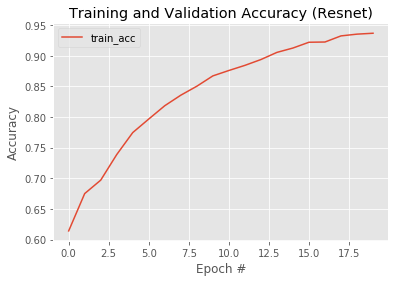

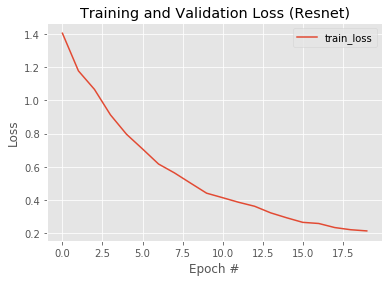

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

# 绘制结果曲线
H = history

N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["accuracy"], label="train_acc")
# plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy (Resnet)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
# plt.savefig('./output/simple_nn_plot_acc.png')
 
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
# plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss (Resnet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig('./output/simple_nn_plot_loss.png')

# 5 中间层提取

In [36]:
from keras import backend as K

f_output = K.function([model.layers[0].input],
                      [model.layers[-2].output])

In [51]:
f = f_output(train_data[0][0])

In [52]:
np.array(f).shape

(1, 256, 2048)

In [50]:
f[0][0]

array([0.0675915 , 0.9739614 , 1.3306484 , ..., 0.10163742, 0.72788626,
       0.05264937], dtype=float32)